In [127]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

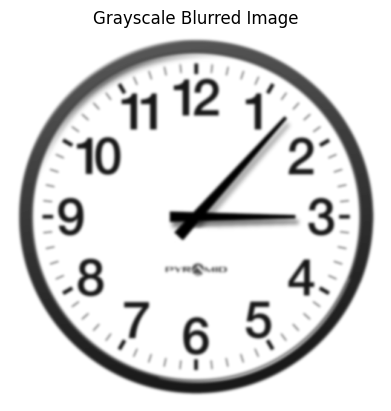

In [128]:
image = cv2.imread('images/1.png')

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (9, 9), 0)

plt.imshow(blurred, cmap='gray')
plt.title("Grayscale Blurred Image")
plt.axis('off')
plt.show()


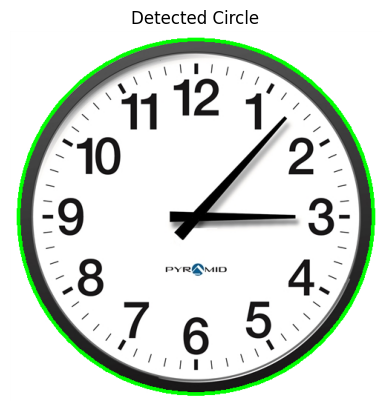

In [129]:
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=500, param1=50, param2=30, minRadius=100, maxRadius=500)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        center = (x, y)
        radius = r
else:
    raise Exception("No circles were found.")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Circle")
plt.axis('off')
plt.show()


In [130]:
_, thresholded = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV)

lines = cv2.HoughLinesP(thresholded, 1, np.pi / 180, 200, minLineLength=radius // 2, maxLineGap=10)

# Separate lines into potential hour and minute hands based on length
if lines is not None:
    hour_hand = None
    minute_hand = None
    max_length = 0
    for line in lines:
        for x1, y1, x2, y2 in line:
            length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            if length > max_length:
                max_length = length
                minute_hand = (x1, y1, x2, y2)
            elif hour_hand is None or length < max_length:
                hour_hand = (x1, y1, x2, y2)

In [131]:
def calculate_angle(line, center):
    x1, y1, x2, y2 = line
    dx, dy = x2 - center[0], center[1] - y2
    angle = math.degrees(math.atan2(dy, dx))

    angle = (90 - angle) % 360
    return angle

minute_angle = calculate_angle(minute_hand, center)
hour_angle = calculate_angle(hour_hand, center)

minute = round(minute_angle / 6)  # Each minute represents 6 degrees
hour = round(hour_angle / 30) % 12  # Each hour represents 30 degrees

print(f"Detected Time: {hour}:{minute:02d}")

Detected Time: 3:07


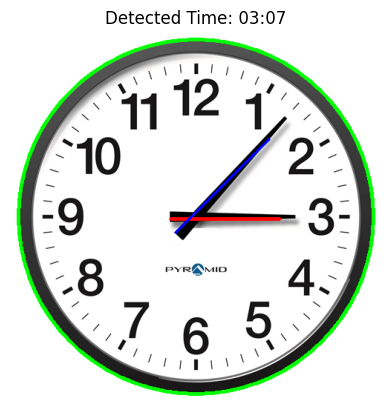

In [133]:
if hour_hand is not None:
    cv2.line(image, (hour_hand[0], hour_hand[1]), (hour_hand[2], hour_hand[3]), (0, 0, 255), 3)

if minute_hand is not None:
    cv2.line(image, (minute_hand[0], minute_hand[1]), (minute_hand[2], minute_hand[3]), (255, 0, 0), 3)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Time: {hour:02d}:{minute:02d}")
plt.axis('off')
plt.show()